In [1]:
import dependent_functions as d_f

In [2]:
### initializations from d_f .py file

import numpy as np
import math
import scipy.stats as stats
from scipy.linalg import sqrtm
import scipy
import matplotlib.pyplot as plt
import time
import datetime
import random
#import statistics

import numba
from numba import jit, njit
from numba.typed import List


### 0.) re-defining the mother function & fdep function to hold SE's

In [3]:
#### changing fdep_oracle for SE's calculation purposes

def fdep_ORACLE_SE(musFDR, musPFDR, musMFDR, olocfdr_packed, maxiter, alpha):

    # "columns order: OMTFDR, OMTpFDR, OMTmFDR ... "
    minprob_mat = np.zeros((1,3),float)
    lev_mat = np.zeros((1,3),float)
    pow_mat = np.zeros((1,3),float)
    ev_mat = np.zeros((1,3),float)
    er_mat = np.zeros((1,3),float)  
    
    # - - - for oracle rule - - -
    a, b, locFDR = d_f.AandB_a_and_b_generator (olocfdr_packed, maxiter)
    print("THIS IS olocfdr_packed SIZE")
    print(olocfdr_packed.size)
    print(len(olocfdr_packed))
    print(olocfdr_packed.shape)

    print("THIS IS olocfdr_packed SIZE")
    print(a.size)
    print(a.shape)
    print("THIS IS olocfdr_packed SIZE")
    print(b.size)
    print(b.shape)
    print("THIS IS olocfdr_packed SIZE")
    print(locFDR.size)
    print(locFDR.shape)

    lev_mat_iter, pow_mat_iter, minprob_mat_iter, ev_mat_iter, er_mat_iter = [], [], [], [], [] 
    
    for iter in range(maxiter): 

        # OMTFDR 
        lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = d_f.FDR_Generic_structure (mus=musFDR, 
                                                                               a=a[iter], 
                                                                               b_1=b[iter], 
                                                                               b_2=b[iter], 
                                                                               ind=0, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat, 
                                                                               olocfdr_function=locFDR[iter],  
                                                                               alpha = alpha)      
         # OMTpFDR 
        lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = d_f.FDR_Generic_structure (mus=musPFDR, 
                                                                               a=a[iter], 
                                                                               b_1=b[iter], 
                                                                               b_2=b[iter], 
                                                                               ind=1, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat, 
                                                                               olocfdr_function=locFDR[iter],  
                                                                               alpha = alpha)    
        # OMTMFDR 
        lev_mat, pow_mat, minprob_mat, ev_mat, er_mat = d_f.FDR_Generic_structure (mus=musMFDR, 
                                                                               a=a[iter-1], 
                                                                               b_1=locFDR[iter] - alpha, 
                                                                               b_2=b[iter], 
                                                                               ind=2, 
                                                                               lev_mat=lev_mat, 
                                                                               pow_mat=pow_mat, 
                                                                               minprob_mat=minprob_mat, 
                                                                               ev_mat=ev_mat, 
                                                                               er_mat=er_mat, 
                                                                               olocfdr_function=locFDR[iter],  
                                                                               alpha = alpha)                  
        lev_mat_iter.append(lev_mat) 
        pow_mat_iter.append(pow_mat) 
        minprob_mat_iter.append(minprob_mat) 
        ev_mat_iter.append(ev_mat) 
        er_mat_iter.append(er_mat)
        
    iterations_list = [lev_mat_iter, pow_mat_iter, minprob_mat_iter, ev_mat_iter, er_mat_iter]
    return lev_mat/maxiter, pow_mat/maxiter, minprob_mat/maxiter, ev_mat/maxiter, er_mat/maxiter, iterations_list







In [4]:
def the_general_mother_SE(musFDR, musPFDR, musMFDR, alpha, mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter):
    
    # initialize
    num_hypo = list(np.array(number_of_blocks) * np.array(number_block_members))
     
    ############################################################ 1.) Generating locfdr & vec_h per group, as a List
    locfdr_unpacked, vec_h_unpacked = d_f.locfdr_generator_all_groups(mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter)
    
    
    
    ############################################################ 2.) SLFDR 
    SLFDR_R = []
    SLFDR_V = []
    for group in range(len(locfdr_unpacked)):
        SLFDR_olocfdr = np.sort(locfdr_unpacked[group], axis=1)
        num_rejections, rejections_olocfdr = d_f.SLFDR_decision_vectorized_rule(SLFDR_olocfdr, alpha)
        vec_h_per_group = np.array([np.concatenate(vec_h_unpacked[group][j]) for j in range(len(vec_h_unpacked[group]))])
        v = d_f.V_generator(locfdr_unpacked[group], vec_h_per_group, num_rejections)
        SLFDR_R.append(num_rejections)
        SLFDR_V.append(v)
    SLFDR_MINPROB = np.where(sum((np.array(SLFDR_R) > 0) + 0) > 1, 1, 0)        
    
    # 2.1.) Calculating the procedure's metrics
    SLFDR_POWER = np.mean(np.sum(SLFDR_R, axis = 0) - np.sum(SLFDR_V, axis = 0))
    SLFDR_POWER_SE = np.std(np.sum(SLFDR_R, axis = 0) - np.sum(SLFDR_V, axis = 0))
    a = np.sum(SLFDR_V, axis = 0) # total V per iteration
    b = np.sum(SLFDR_R, axis = 0) # total R per iteration
    SLFDR_FDR_DIVIDE = np.divide(a, b, out=np.zeros(a.shape, dtype=float), where=b!=0)
    SLFDR_FDR = np.mean(SLFDR_FDR_DIVIDE) 
    SLFDR_FDR_SE = np.std(SLFDR_FDR_DIVIDE)
    
        
    if (np.mean(np.sum(SLFDR_R, axis = 0)) != 0) & (np.std(np.sum(SLFDR_R, axis = 0)) != 0):
        SLFDR_MFDR = np.mean(np.sum(SLFDR_V, axis = 0)) / np.mean(np.sum(SLFDR_R, axis = 0))
        SLFDR_MFDR_SE = np.std(np.sum(SLFDR_V, axis = 0)) / np.std(np.sum(SLFDR_R, axis = 0))  
        """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    else:
        SLFDR_MFDR = 0
        SLFDR_MFDR_SE = 0
        
    if (np.mean(SLFDR_MINPROB) != 0) & (np.std(SLFDR_MINPROB) != 0):
        SLFDR_PFDR = SLFDR_FDR / np.mean(SLFDR_MINPROB)
        SLFDR_PFDR_SE = SLFDR_FDR_SE / np.std(SLFDR_MINPROB)
        """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    else:
        SLFDR_PFDR = 0
        SLFDR_PFDR_SE = 0
        
    SLFDR_FNR = d_f.FNR(num_hypo, prob_to_1, np.mean(np.sum(SLFDR_R, axis = 0)), np.mean(np.sum(SLFDR_V, axis = 0)))
    slfdr_fnr_r_vec_to_SE = []
    for i in range(maxiter):
        slfdr_fnr_r_vec_to_SE.append(d_f.FNR(num_hypo, prob_to_1, np.sum(SLFDR_R, axis = 0)[i], np.sum(SLFDR_V, axis = 0)[i]))
    SLFDR_FNR_SE = np.std(np.array(slfdr_fnr_r_vec_to_SE))
        
    slfdr_list = [SLFDR_POWER, SLFDR_POWER_SE, SLFDR_FNR, SLFDR_FNR_SE, SLFDR_FDR, SLFDR_FDR_SE, SLFDR_MFDR, SLFDR_MFDR_SE, SLFDR_PFDR, SLFDR_PFDR_SE]
    
    
    ############################################################ 3.) packing locfdr & vec_h together for the rest 4 procedures 
    locfdr_packed = d_f.locfdr_concator(locfdr_unpacked)
    vec_h_packed = d_f.vec_h_concator(vec_h_unpacked)
    olocfdr_packed = np.sort(locfdr_packed, axis=1)
    
    ############################################################ 4.) CLFDR
    CLFDR_R, rejections_olocfdr_list = d_f.SLFDR_decision_vectorized_rule(olocfdr_packed, alpha)
    CLFDR_V = d_f.V_generator(locfdr_packed, vec_h_packed, CLFDR_R)
    CLFDR_MINPROB = (np.array(CLFDR_R) > 0) + 0
    
    # 4.1.) Calculating the procedure's metrics
    CLFDR_POWER = np.mean(np.array(CLFDR_R) - np.array(CLFDR_V))
    CLFDR_POWER_SE = np.std(np.array(CLFDR_R) - np.array(CLFDR_V))
    aa = np.array(CLFDR_V)
    bb = np.array(CLFDR_R)
    CLFDR_FDR_DIVIDE = np.divide(aa, bb, out=np.zeros(aa.shape, dtype=float), where=bb!=0)
    CLFDR_FDR = np.mean(CLFDR_FDR_DIVIDE)
    CLFDR_FDR_SE = np.std(CLFDR_FDR_DIVIDE)
    if (np.mean(CLFDR_R) != 0) & (np.std(CLFDR_R) != 0):
        CLFDR_MFDR = np.mean(CLFDR_V) / np.mean(CLFDR_R)
        CLFDR_MFDR_SE = np.std(CLFDR_V) / np.std(CLFDR_R)
        """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """        
    else:
        CLFDR_MFDR = 0
        CLFDR_MFDR_SE = 0
    if (np.mean(CLFDR_MINPROB) != 0) & (np.std(CLFDR_MINPROB) != 0):
        CLFDR_PFDR = CLFDR_FDR / np.mean(CLFDR_MINPROB)
        CLFDR_PFDR_SE = CLFDR_FDR_SE / np.std(CLFDR_MINPROB)
        """ I'M TOTALLY NOT SURE ABOUT IT - IT'S BECAUSE I DON'T HAVE THE VARIANCE OF EACH MEAN """
    else:
        CLFDR_PFDR = 0
        CLFDR_PFDR_SE = 0
    CLFDR_FNR = d_f.FNR(num_hypo, prob_to_1, np.mean(CLFDR_R), np.mean(CLFDR_V))
    clfdr_fnr_r_vec_to_SE = []
    for i in range(maxiter):
        clfdr_fnr_r_vec_to_SE.append(d_f.FNR(num_hypo, prob_to_1, CLFDR_R[i], CLFDR_V[i]))
    CLFDR_FNR_SE = np.std(np.array(clfdr_fnr_r_vec_to_SE))
 
    clfdr_list = [CLFDR_POWER, CLFDR_POWER_SE, CLFDR_FNR, CLFDR_FNR_SE, CLFDR_FDR, CLFDR_FDR_SE, CLFDR_MFDR, CLFDR_MFDR_SE, CLFDR_PFDR, CLFDR_PFDR_SE]
    
    ############################################################ 5.) R&S
    lev_mat_r, pow_mat_r, minprob_mat_r, ev_mat_r, er_mat_r, iterations_list = fdep_ORACLE_SE(musFDR, musPFDR, musMFDR, olocfdr_packed, maxiter, alpha)
    
    # 5.0.) initializing variables for SE calculations
    # index: 0: FDR, 1: MFDR, 2: PFDR
    # 50 length, each component has 3, so in order to create an "FDR" pure vector, we need to add each [0] component from the 50 to another vector

    lev_mat_r_isolated = iterations_list[0] 
    lev_mat_r_isolated_FDR = np.array([lev_mat_r_isolated[j][0][0] for j in range(maxiter)])
    lev_mat_r_isolated_MFDR = np.array([lev_mat_r_isolated[j][0][1] for j in range(maxiter)])
    lev_mat_r_isolated_PFDR = np.array([lev_mat_r_isolated[j][0][2] for j in range(maxiter)])
    
    pow_mat_r_isolated = iterations_list[1] 
    pow_mat_r_isolated_FDR = np.array([pow_mat_r_isolated[j][0][0] for j in range(maxiter)])
    pow_mat_r_isolated_MFDR = np.array([pow_mat_r_isolated[j][0][1] for j in range(maxiter)])
    pow_mat_r_isolated_PFDR = np.array([pow_mat_r_isolated[j][0][2] for j in range(maxiter)])    
    
    minprob_mat_r_isolated = iterations_list[2]
    minprob_mat_r_isolated_FDR = np.array([minprob_mat_r_isolated[j][0][0] for j in range(maxiter)])
    minprob_mat_r_isolated_MFDR = np.array([minprob_mat_r_isolated[j][0][1] for j in range(maxiter)])
    minprob_mat_r_isolated_PFDR = np.array([minprob_mat_r_isolated[j][0][2] for j in range(maxiter)])  
    
    ev_mat_r_isolated = iterations_list[3]
    ev_mat_r_isolated_FDR = np.array([ev_mat_r_isolated[j][0][0] for j in range(maxiter)])
    ev_mat_r_isolated_MFDR = np.array([ev_mat_r_isolated[j][0][1] for j in range(maxiter)])
    ev_mat_r_isolated_PFDR = np.array([ev_mat_r_isolated[j][0][2] for j in range(maxiter)])      
    
    er_mat_r_isolated = iterations_list[4]
    er_mat_r_isolated_FDR = np.array([er_mat_r_isolated[j][0][0] for j in range(maxiter)])
    er_mat_r_isolated_MFDR = np.array([er_mat_r_isolated[j][0][1] for j in range(maxiter)])
    er_mat_r_isolated_PFDR = np.array([er_mat_r_isolated[j][0][2] for j in range(maxiter)])
                                      
                                      
    # 5.1.) OMTFDR control
    OMTFDR_power = pow_mat_r[0][0]
    OMTFDR_power_SE = np.std(pow_mat_r_isolated_FDR)                                  
    OMTFDR_fdr = lev_mat_r[0][0]
    OMTFDR_fdr_SE = np.std(lev_mat_r_isolated_FDR)                                  
    OMTFDR_mfdr = ev_mat_r[0][0] / er_mat_r[0][0]
    if np.std(er_mat_r_isolated_FDR) != 0:
        OMTFDR_mfdr_SE = np.std(ev_mat_r_isolated_FDR) / np.std(er_mat_r_isolated_FDR)
    else:
        OMTFDR_mfdr_SE = 0
        
    OMTFDR_pfdr = lev_mat_r[0][0] / minprob_mat_r[0][0]
    if np.std(minprob_mat_r_isolated_FDR) != 0:
        OMTFDR_pfdr_SE = np.std(lev_mat_r_isolated_FDR) / np.std(minprob_mat_r_isolated_FDR)
    else:
        OMTFDR_pfdr_SE = 0
        
    OMTFDR_fnr = d_f.FNR(num_hypo, prob_to_1, er_mat_r[0][0], ev_mat_r[0][0])     
    OMTFDR_fnr_vec_to_SE = []
    for i in range(maxiter):
        OMTFDR_fnr_vec_to_SE.append(d_f.FNR(num_hypo, prob_to_1, er_mat_r_isolated_FDR[i], ev_mat_r_isolated_FDR[i]))
    OMTFDR_fnr_SE = np.std(np.array(OMTFDR_fnr_vec_to_SE))
            
    OMTFDR_list = [OMTFDR_power, OMTFDR_power_SE, OMTFDR_fnr, OMTFDR_fnr_SE, OMTFDR_fdr, OMTFDR_fdr_SE, OMTFDR_mfdr, OMTFDR_mfdr_SE, OMTFDR_pfdr, OMTFDR_pfdr_SE]
    
    # 5.2.) OMTpFDR control
    OMTpFDR_power = pow_mat_r[0][1]
    OMTpFDR_power_SE = np.std(pow_mat_r_isolated_PFDR)                                  
    OMTpFDR_fdr = lev_mat_r[0][1]
    OMTpFDR_fdr_SE = np.std(lev_mat_r_isolated_PFDR)                                  
    OMTpFDR_mfdr = ev_mat_r[0][1] / er_mat_r[0][1]
    if np.std(er_mat_r_isolated_PFDR) != 0:
        OMTpFDR_mfdr_SE = np.std(ev_mat_r_isolated_PFDR) / np.std(er_mat_r_isolated_PFDR)
    else:
        OMTpFDR_mfdr_SE = 0
        
    OMTpFDR_pfdr = lev_mat_r[0][1] / minprob_mat_r[0][1]
    if np.std(minprob_mat_r_isolated_PFDR) != 0:
        OMTpFDR_pfdr_SE = np.std(lev_mat_r_isolated_PFDR) / np.std(minprob_mat_r_isolated_PFDR)
    else:
        OMTpFDR_pfdr_SE = 0     
        
    OMTpFDR_fnr = d_f.FNR(num_hypo, prob_to_1, er_mat_r[0][1], ev_mat_r[0][1]) 
    OMTpFDR_fnr_vec_to_SE = []
    for i in range(maxiter):
        OMTpFDR_fnr_vec_to_SE.append(d_f.FNR(num_hypo, prob_to_1, er_mat_r_isolated_PFDR[i], ev_mat_r_isolated_PFDR[i]))
    OMTpFDR_fnr_SE = np.std(np.array(OMTpFDR_fnr_vec_to_SE))
    
    OMTpFDR_list = [OMTpFDR_power, OMTpFDR_power_SE, OMTpFDR_fnr, OMTpFDR_fnr_SE, OMTpFDR_fdr, OMTpFDR_fdr_SE, OMTpFDR_mfdr, OMTpFDR_mfdr_SE, OMTpFDR_pfdr, OMTpFDR_pfdr_SE]
    
    # 5.3.) OMTmFDR control
    OMTmFDR_power = pow_mat_r[0][2]
    OMTmFDR_power_SE = np.std(pow_mat_r_isolated_MFDR)                                  
    OMTmFDR_fdr = lev_mat_r[0][2]
    OMTmFDR_fdr_SE = np.std(lev_mat_r_isolated_MFDR)                                  
    OMTmFDR_mfdr = ev_mat_r[0][2] / er_mat_r[0][2]
    if np.std(er_mat_r_isolated_MFDR) != 0:
        OMTmFDR_mfdr_SE = np.std(ev_mat_r_isolated_MFDR) / np.std(er_mat_r_isolated_MFDR)
    else:
        OMTmFDR_mfdr_SE = 0
        
    OMTmFDR_pfdr = lev_mat_r[0][2] / minprob_mat_r[0][2]
    if np.std(minprob_mat_r_isolated_MFDR) != 0:
        OMTmFDR_pfdr_SE = np.std(lev_mat_r_isolated_MFDR) / np.std(minprob_mat_r_isolated_MFDR)
    else:
        OMTmFDR_pfdr_SE = 0
        
    OMTmFDR_fnr = d_f.FNR(num_hypo, prob_to_1, er_mat_r[0][2], ev_mat_r[0][2]) 
    OMTmFDR_fnr_vec_to_SE = []
    for i in range(maxiter):
        OMTmFDR_fnr_vec_to_SE.append(d_f.FNR(num_hypo, prob_to_1, er_mat_r_isolated_MFDR[i], ev_mat_r_isolated_MFDR[i]))
    OMTmFDR_fnr_SE = np.std(np.array(OMTmFDR_fnr_vec_to_SE))
        
    
    OMTmFDR_list = [OMTmFDR_power, OMTmFDR_power_SE, OMTmFDR_fnr, OMTmFDR_fnr_SE, OMTmFDR_fdr, OMTmFDR_fdr_SE, OMTmFDR_mfdr, OMTmFDR_mfdr_SE, OMTmFDR_pfdr, OMTmFDR_pfdr_SE]

    return slfdr_list, clfdr_list, OMTFDR_list, OMTpFDR_list, OMTmFDR_list

In [5]:
# %%time
# #### demo credentials

# alpha = 0.1

# variance_0 = [1, 1]
# variance_1 = [0.01, 0.01]

# mu0 = [0, 0]
# mu1 = [-1.5, -1.5]

# number_of_blocks = [60, 60]
# number_block_members = [5, 5]

# prob_to_1 = [0.3, 0.3]

# ### the varying variable Rho = [0.5, 0.5]  


# """ DEPENDENT """
# # simulation values

# # RHO
# rho_simulation_3sample = [0, 0.1, 0.5]

# # Procedure Mu's
# musFDR_scalar_3sample1 = [463.7551664, 469.3152023, 505.9141851]
# musPFDR_scalar_3sample1 = [466.4244535, 469.6646385, 505.6431355]
# musMFDR_scalar_3sample1 = [7.490934228, 7.451234746, 5.966122862]



# maxiter = 5000 #00 

# slfdr = []
# clfdr = []
# rs_FDR = []
# rs_pFDR = []
# rs_mFDR = []

# for i in range(len(rho_simulation_3sample)):
    
#     Rho = [rho_simulation_3sample[i], 0.5]
#     musFDR_scalar = [musFDR_scalar_3sample1[i]]
#     musPFDR_scalar = [musPFDR_scalar_3sample1[i]] 
#     musMFDR_scalar = [musMFDR_scalar_3sample1[i]]
    
#     #the_general_mother_SE2
#     the_general_mother_SE(musFDR_scalar, musPFDR_scalar, musMFDR_scalar, alpha, mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter)

# #    slfdr_list, clfdr_list, OMTFDR_list, OMTpFDR_list, OMTmFDR_list = the_general_mother_SE(musFDR_scalar, musPFDR_scalar, musMFDR_scalar, alpha, mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter)


In [5]:
def present_max_SE (string, list_input):
    
    max_power = max(list_input[0][0],list_input[1][0],list_input[2][0])
    print(f"for pocedure {string}, the maximal SE for Power(E(TP)) is:" + str(max_power))
    
    max_fdr = max(list_input[0][1],list_input[1][1],list_input[2][1])
    print(f"for pocedure {string}, the maximal SE for FDR is:" + str(max_fdr))
    
    max_mfdr = max(list_input[0][2],list_input[1][2],list_input[2][2])
    print(f"for pocedure {string}, the maximal SE for mFDR is:" + str(max_mfdr) )
    
    max_pfdr = max(list_input[0][3],list_input[1][3],list_input[2][3])
    print(f"for pocedure {string}, the maximal SE for pFDR is:" + str(max_pfdr))
    
    max_fnr = max(list_input[0][4],list_input[1][4],list_input[2][4])
    print(f"for pocedure {string}, the maximal SE for fnr is:" + str(max_fnr))


# present_max_SE("SLFDR",slfdr_SE11)

### ----------------------------------------
### 1.) study 1# - setting 1 - same group, different rho on the first group
### ----------------------------------------

In [6]:
alpha = 0.1

variance_0 = [1, 1]
variance_1 = [0.01, 0.01]

mu0 = [0, 0]
mu1 = [-1.5, -1.5]

number_of_blocks = [60, 60]
number_block_members = [5, 5]

prob_to_1 = [0.3, 0.3]

### the varying variable Rho = [0.5, 0.5]  

In [7]:
""" DEPENDENT """
# simulation values

# RHO
rho_simulation_3sample = [0, 0.1, 0.5]

# Procedure Mu's
musFDR_scalar_3sample1 = [463.7551664, 469.3152023, 505.9141851]
musPFDR_scalar_3sample1 = [466.4244535, 469.6646385, 505.6431355]
musMFDR_scalar_3sample1 = [7.490934228, 7.451234746, 5.966122862]


In [8]:
%%time

maxiter = 5000 

slfdr = []
clfdr = []
rs_FDR = []
rs_pFDR = []
rs_mFDR = []

for i in range(len(rho_simulation_3sample)):
    
    Rho = [rho_simulation_3sample[i], 0.5]
    musFDR_scalar = [musFDR_scalar_3sample1[i]]
    musPFDR_scalar = [musPFDR_scalar_3sample1[i]] 
    musMFDR_scalar = [musMFDR_scalar_3sample1[i]]
    
    slfdr_list, clfdr_list, OMTFDR_list, OMTpFDR_list, OMTmFDR_list = the_general_mother_SE(musFDR_scalar, musPFDR_scalar, musMFDR_scalar, alpha, mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter)

    slfdr.append(slfdr_list)
    clfdr.append(clfdr_list)
    rs_FDR.append(OMTFDR_list)
    rs_pFDR.append(OMTpFDR_list)
    rs_mFDR.append(OMTmFDR_list)

 * * * BLOCKS START: 
 * * * BLOCKS time: 0.14637207984924316
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
 * * * BLOCK BETA time: 33.4976270198822
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
loop no.: 1
loop no.: 2
loop no.: 3
 * * * AANDB LOCFDR GENERATOR time: 17.524261713027954
 * * * BLOCKS START: 
 * * * BLOCKS time: 0.1515944004058838
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
 * * * BLOCK BETA time: 36.101773500442505
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
loop no.: 1
loop no.: 2
loop no.: 3
 * * * AANDB LOCFDR GENERATOR time: 17.67724895477295
THIS IS olocfdr_packed SIZE
3000000
5000
(5000, 600, 1)
THIS IS olocfdr_packed SIZE
3000000
(5000, 600)
THIS IS olocfdr_packed SIZE
3000000
(5000, 600)
THIS IS olocfdr_packed SIZE
3000000
(5000, 600)
 * * * BLOCKS START: 
 * * * BLOCKS time: 0.13234829902648926
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
 * * * BLOCK BETA time: 35.07284188270569
 * * * AANDB LOCFDR GENERATOR START: 
loop 

In [9]:
# ## OLD version
# %%time
# d_f.plot_4_metrics(rho_simulation_3sample, slfdr, clfdr, rs_FDR, rs_pFDR, rs_mFDR)

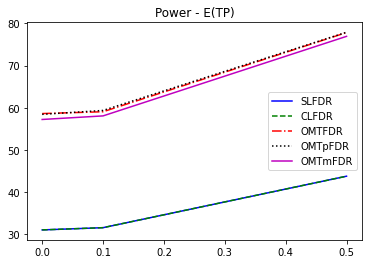

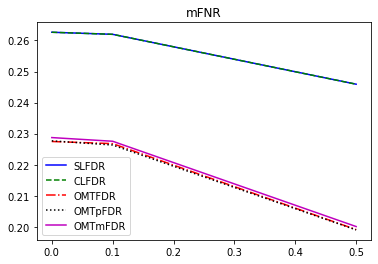

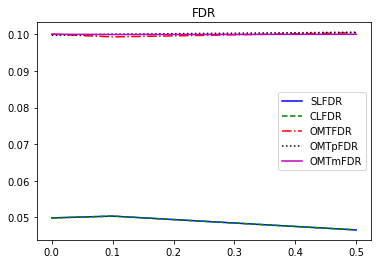

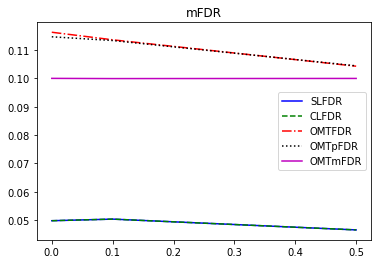

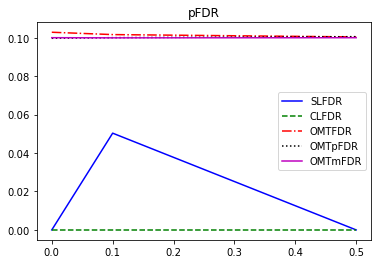

Wall time: 705 ms


In [9]:
%%time
### ^ this will have to be changed to something like this:

slfdr_, slfdr_SE, clfdr_, clfdr_SE, rs_FDR_, rs_FDR_SE, rs_pFDR_ , rs_pFDR_SE = [],[],[],[],[],[],[],[]
rs_mFDR_, rs_mFDR_SE, rs_pFDR_pooled_, rs_pFDR_pooled_SE =  [],[],[],[]

for i in range(len(rho_simulation_3sample)):
    slfdr_.append([slfdr[i][0], slfdr[i][2], slfdr[i][4], slfdr[i][6], slfdr[i][8]])
    slfdr_SE.append([slfdr[i][1], slfdr[i][3], slfdr[i][5], slfdr[i][7], slfdr[i][9]])
    clfdr_.append([clfdr[i][0], clfdr[i][2], clfdr[i][4], clfdr[i][6], clfdr[i][8]])
    clfdr_SE.append([clfdr[i][1], clfdr[i][3], clfdr[i][5], clfdr[i][7], clfdr[i][9]])
    rs_FDR_.append([rs_FDR[i][0], rs_FDR[i][2], rs_FDR[i][4], rs_FDR[i][6], rs_FDR[i][8]])
    rs_FDR_SE.append([rs_FDR[i][1], rs_FDR[i][3], rs_FDR[i][5], rs_FDR[i][7], rs_FDR[i][9]]) 
    rs_pFDR_.append([rs_pFDR[i][0], rs_pFDR[i][2], rs_pFDR[i][4], rs_pFDR[i][6], rs_pFDR[i][8]])
    rs_pFDR_SE.append([rs_pFDR[i][1], rs_pFDR[i][3], rs_pFDR[i][5], rs_pFDR[i][7], rs_pFDR[i][9]]) 
    rs_mFDR_.append([rs_mFDR[i][0], rs_mFDR[i][2], rs_mFDR[i][4], rs_mFDR[i][6], rs_mFDR[i][8]])
    rs_mFDR_SE.append([rs_mFDR[i][1], rs_mFDR[i][3], rs_mFDR[i][5], rs_mFDR[i][7], rs_mFDR[i][9]])  


d_f.plot_4_metrics(rho_simulation_3sample, slfdr_, clfdr_, rs_FDR_, rs_pFDR_, rs_mFDR_)

#### 1.2.) August 2022 - numbers for a potential table report 

In [10]:
rho_simulation_3sample, slfdr_, clfdr_, rs_FDR_, rs_pFDR_, rs_mFDR_

([0, 0.1, 0.5],
 [[30.9724,
   0.26264840852204974,
   0.049860687745325837,
   0.049827282600025766,
   0],
  [31.505,
   0.2619776325316253,
   0.050354271106195975,
   0.050390634419232715,
   0.05036434397499097],
  [43.7282,
   0.24591796370272093,
   0.04658045551923119,
   0.046584744727983116,
   0]],
 [[30.9724,
   0.26264840852204974,
   0.049860687745325837,
   0.049827282600025766,
   0],
  [31.505, 0.2619776325316253, 0.050354271106195975, 0.050390634419232715, 0],
  [43.7282,
   0.24591796370272093,
   0.04658045551923119,
   0.046584744727983116,
   0]],
 [[58.60505070234514,
   0.22746503338039267,
   0.10007651499868526,
   0.11624653236060847,
   0.10289586160670909],
  [59.03312794240086,
   0.2267834316098182,
   0.09933574253494584,
   0.11358209265826018,
   0.10167425029165389],
  [77.84122950370423,
   0.19910241170238874,
   0.10046140271033559,
   0.10427866454357221,
   0.10046140271033559]],
 [[58.41457638732898,
   0.2276789349877574,
   0.099748620485613,


#### 1.3.) March 2023 - Maximum SE numbers

In [11]:
# SE's: 
slfdr_SE, clfdr_SE, rs_FDR_SE, rs_pFDR_SE, rs_mFDR_SE

([[5.179810637465428,
   0.006793495202102772,
   0.03854416070606254,
   0.24093860608162246,
   0],
  [5.164065743191115,
   0.006787034817339074,
   0.039040755488349094,
   0.2481332713641074,
   2.760874396091118],
  [5.949783589341716,
   0.008166009940948508,
   0.031481979939180005,
   0.24190454481598103,
   0]],
 [[5.179810637465428,
   0.006793495202102772,
   0.03854416070606254,
   0.24093860608162246,
   0],
  [5.164065743191115,
   0.006787034817339074,
   0.039040755488349094,
   0.2481332713641074,
   0],
  [5.949783589341716,
   0.008166009940948508,
   0.031481979939180005,
   0.24190454481598103,
   0]],
 [[0.0, 1.1102230246251565e-16, 5.684341886080802e-14, 0, 0],
  [5.820766091346741e-11,
   1.1102230246251565e-16,
   1.1368683772161603e-13,
   0,
   0],
  [0.0, 0.0, 0.0, 0, 0]],
 [[0.0, 2.220446049250313e-16, 1.1368683772161603e-13, 0, 0],
  [0.0, 0.0, 5.684341886080802e-14, 0, 0],
  [5.820766091346741e-11, 2.220446049250313e-16, 0.0, 0, 0]],
 [[5.820766091346741

In [12]:
present_max_SE("SLFDR_simu1",slfdr_SE)
print("-")
present_max_SE("CLFDR_simu1",clfdr_SE)
print("-")
present_max_SE("FDR_simu1",rs_FDR_SE)
print("-")
present_max_SE("pFDR_simu1",rs_pFDR_SE)
print("-")
present_max_SE("mFDR_simu1",rs_mFDR_SE)

for pocedure SLFDR_simu1, the maximal SE for Power(E(TP)) is:5.949783589341716
for pocedure SLFDR_simu1, the maximal SE for FDR is:0.008166009940948508
for pocedure SLFDR_simu1, the maximal SE for mFDR is:0.039040755488349094
for pocedure SLFDR_simu1, the maximal SE for pFDR is:0.2481332713641074
for pocedure SLFDR_simu1, the maximal SE for fnr is:2.760874396091118
-
for pocedure CLFDR_simu1, the maximal SE for Power(E(TP)) is:5.949783589341716
for pocedure CLFDR_simu1, the maximal SE for FDR is:0.008166009940948508
for pocedure CLFDR_simu1, the maximal SE for mFDR is:0.039040755488349094
for pocedure CLFDR_simu1, the maximal SE for pFDR is:0.2481332713641074
for pocedure CLFDR_simu1, the maximal SE for fnr is:0
-
for pocedure FDR_simu1, the maximal SE for Power(E(TP)) is:5.820766091346741e-11
for pocedure FDR_simu1, the maximal SE for FDR is:1.1102230246251565e-16
for pocedure FDR_simu1, the maximal SE for mFDR is:1.1368683772161603e-13
for pocedure FDR_simu1, the maximal SE for pFDR 

### ----------------------------------------
### 2.) study 1# - setting 2 - different group size, different rho on the first group - ALPHA IS ACCIDENTALY EQUAL TO 0.05 AND NOT 0.1
### ----------------------------------------

In [13]:
alpha = 0.05

variance_0 = [1, 1]
variance_1 = [0.01, 0.01]

mu0 = [0, 0]
mu1 = [-1.5, -1.5]

number_of_blocks = [30, 90]
number_block_members = [5, 5]

prob_to_1 = [0.3, 0.3]

### the varying variable Rho = [0.5, 0.5]  

In [14]:
""" DEPENDENT """
# simulation values

# RHO
rho_simulation_3sample = [0, 0.1, 0.5]

# Procedure Mu's
musFDR_scalar_3sample2 = [640.9788633, 644.346699, 723.6224254]
musPFDR_scalar_3sample2 = [647.4635543, 651.4380059, 727.9847655]
musMFDR_scalar_3sample2 = [16.455497, 16.49222222, 15.28647862]

In [15]:
%%time

maxiter = 5000 

slfdr = []
clfdr = []
rs_FDR = []
rs_pFDR = []
rs_mFDR = []

for i in range(len(rho_simulation_3sample)):
    
    Rho = [rho_simulation_3sample[i], 0.5]
    musFDR_scalar = [musFDR_scalar_3sample2[i]]
    musPFDR_scalar = [musPFDR_scalar_3sample2[i]] 
    musMFDR_scalar = [musMFDR_scalar_3sample2[i]]
    
    slfdr_list, clfdr_list, OMTFDR_list, OMTpFDR_list, OMTmFDR_list = the_general_mother_SE(musFDR_scalar, musPFDR_scalar, musMFDR_scalar, alpha, mu0, variance_0, mu1, variance_1, number_of_blocks, number_block_members, Rho, prob_to_1, maxiter)

    slfdr.append(slfdr_list)
    clfdr.append(clfdr_list)
    rs_FDR.append(OMTFDR_list)
    rs_pFDR.append(OMTpFDR_list)
    rs_mFDR.append(OMTmFDR_list)

 * * * BLOCKS START: 
 * * * BLOCKS time: 0.06247210502624512
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
 * * * BLOCK BETA time: 17.054328441619873
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
loop no.: 1
loop no.: 2
loop no.: 3
 * * * AANDB LOCFDR GENERATOR time: 8.944394826889038
 * * * BLOCKS START: 
 * * * BLOCKS time: 0.1874842643737793
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
 * * * BLOCK BETA time: 54.39744997024536
 * * * AANDB LOCFDR GENERATOR START: 
loop no.: 0
loop no.: 1
loop no.: 2
loop no.: 3
 * * * AANDB LOCFDR GENERATOR time: 26.263112545013428
THIS IS olocfdr_packed SIZE
3000000
5000
(5000, 600, 1)
THIS IS olocfdr_packed SIZE
3000000
(5000, 600)
THIS IS olocfdr_packed SIZE
3000000
(5000, 600)
THIS IS olocfdr_packed SIZE
3000000
(5000, 600)
 * * * BLOCKS START: 
 * * * BLOCKS time: 0.0723106861114502
 * * * BLOCK BETA START: 
A
b
new_h
new_c
sqrtmat
beta
 * * * BLOCK BETA time: 17.4201557636261
 * * * AANDB LOCFDR GENERATOR START: 
loop n

In [16]:
## OLD version
#%%time
#d_f.plot_4_metrics(rho_simulation_3sample, slfdr, clfdr, rs_FDR, rs_pFDR, rs_mFDR)

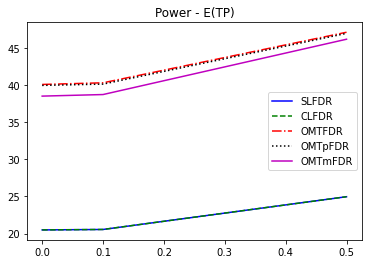

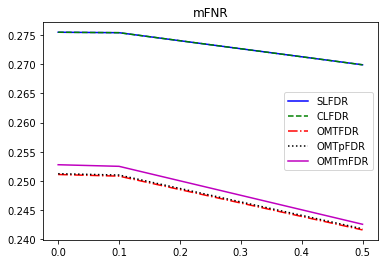

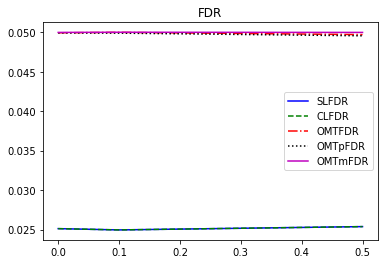

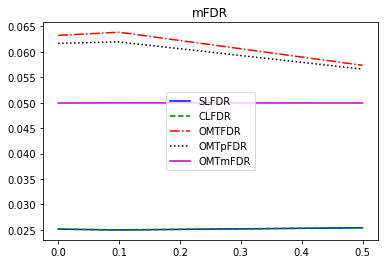

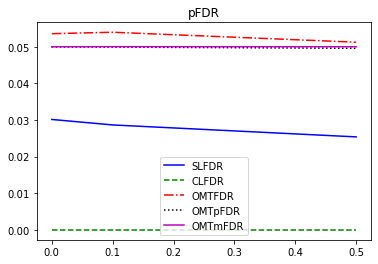

Wall time: 728 ms


In [17]:
%%time
### ^ this will have to be changed to something like this:

slfdr_, slfdr_SE, clfdr_, clfdr_SE, rs_FDR_, rs_FDR_SE, rs_pFDR_ , rs_pFDR_SE = [],[],[],[],[],[],[],[]
rs_mFDR_, rs_mFDR_SE, rs_pFDR_pooled_, rs_pFDR_pooled_SE =  [],[],[],[]

for i in range(len(rho_simulation_3sample)):
    slfdr_.append([slfdr[i][0], slfdr[i][2], slfdr[i][4], slfdr[i][6], slfdr[i][8]])
    slfdr_SE.append([slfdr[i][1], slfdr[i][3], slfdr[i][5], slfdr[i][7], slfdr[i][9]])
    clfdr_.append([clfdr[i][0], clfdr[i][2], clfdr[i][4], clfdr[i][6], clfdr[i][8]])
    clfdr_SE.append([clfdr[i][1], clfdr[i][3], clfdr[i][5], clfdr[i][7], clfdr[i][9]])
    rs_FDR_.append([rs_FDR[i][0], rs_FDR[i][2], rs_FDR[i][4], rs_FDR[i][6], rs_FDR[i][8]])
    rs_FDR_SE.append([rs_FDR[i][1], rs_FDR[i][3], rs_FDR[i][5], rs_FDR[i][7], rs_FDR[i][9]]) 
    rs_pFDR_.append([rs_pFDR[i][0], rs_pFDR[i][2], rs_pFDR[i][4], rs_pFDR[i][6], rs_pFDR[i][8]])
    rs_pFDR_SE.append([rs_pFDR[i][1], rs_pFDR[i][3], rs_pFDR[i][5], rs_pFDR[i][7], rs_pFDR[i][9]]) 
    rs_mFDR_.append([rs_mFDR[i][0], rs_mFDR[i][2], rs_mFDR[i][4], rs_mFDR[i][6], rs_mFDR[i][8]])
    rs_mFDR_SE.append([rs_mFDR[i][1], rs_mFDR[i][3], rs_mFDR[i][5], rs_mFDR[i][7], rs_mFDR[i][9]])  


d_f.plot_4_metrics(rho_simulation_3sample, slfdr_, clfdr_, rs_FDR_, rs_pFDR_, rs_mFDR_)

### 2.2.) August 2022 - numbers for a potential table report 

In [18]:
rho_simulation_3sample, slfdr_, clfdr_, rs_FDR_, rs_pFDR_, rs_mFDR_

([0, 0.1, 0.5],
 [[20.496,
   0.27549318953007057,
   0.02511122326767188,
   0.025104881134713992,
   0.030138290047613873],
  [20.5564,
   0.2754168383952529,
   0.024948645308545618,
   0.02495897090491685,
   0.028643680032773386],
  [24.9684,
   0.26991055072465786,
   0.025368646811023958,
   0.02537999734567853,
   0.025383877137306343]],
 [[20.496, 0.27549318953007057, 0.02511122326767188, 0.025104881134713992, 0],
  [20.5564, 0.2754168383952529, 0.024948645308545618, 0.02495897090491685, 0],
  [24.9684,
   0.26991055072465786,
   0.025368646811023958,
   0.02537999734567853,
   0]],
 [[40.0902396266186,
   0.25109306768268447,
   0.04993684272888501,
   0.0632508756035753,
   0.05354583179164166],
  [40.31230412265191,
   0.25081399790595515,
   0.04999053462765142,
   0.06386739020282355,
   0.05393885911485911],
  [47.12174008228811,
   0.24159200437393405,
   0.049706199534028474,
   0.05735781707399287,
   0.05122238204248606]],
 [[39.96114797628601,
   0.2512306023479131,

#### 2.3.) March 2023 - Maximum SE numbers

In [19]:
# SE's
slfdr_SE, clfdr_SE, rs_FDR_SE, rs_pFDR_SE, rs_mFDR_SE

([[4.2886342814467175,
   0.005396601395000206,
   0.03585265479701661,
   0.1715355304262155,
   0.0961720039941489],
  [4.308273324662677,
   0.005419774596672501,
   0.034433978357618925,
   0.16447011817190302,
   0.10272668403012102],
  [4.667226311204547,
   0.00596086871106494,
   0.0317455049731848,
   0.17171956927085383,
   1.296393790013708]],
 [[4.2886342814467175,
   0.005396601395000206,
   0.03585265479701661,
   0.1715355304262155,
   0],
  [4.308273324662677,
   0.005419774596672501,
   0.034433978357618925,
   0.16447011817190302,
   0],
  [4.667226311204547,
   0.00596086871106494,
   0.0317455049731848,
   0.17171956927085383,
   0]],
 [[2.9103830456733704e-11,
   1.1102230246251565e-16,
   5.684341886080802e-14,
   0,
   0],
  [5.820766091346741e-11, 2.220446049250313e-16, 5.684341886080802e-14, 0, 0],
  [8.731149137020111e-11,
   1.1102230246251565e-16,
   2.842170943040401e-14,
   0,
   0]],
 [[2.9103830456733704e-11, 0.0, 5.684341886080802e-14, 0, 0],
  [0.0, 1.

In [20]:
present_max_SE("SLFDR_simu2",slfdr_SE)
print("-")
present_max_SE("CLFDR_simu2",clfdr_SE)
print("-")
present_max_SE("FDR_simu2",rs_FDR_SE)
print("-")
present_max_SE("pFDR_simu2",rs_pFDR_SE)
print("-")
present_max_SE("mFDR_simu2",rs_mFDR_SE)

for pocedure SLFDR_simu2, the maximal SE for Power(E(TP)) is:4.667226311204547
for pocedure SLFDR_simu2, the maximal SE for FDR is:0.00596086871106494
for pocedure SLFDR_simu2, the maximal SE for mFDR is:0.03585265479701661
for pocedure SLFDR_simu2, the maximal SE for pFDR is:0.17171956927085383
for pocedure SLFDR_simu2, the maximal SE for fnr is:1.296393790013708
-
for pocedure CLFDR_simu2, the maximal SE for Power(E(TP)) is:4.667226311204547
for pocedure CLFDR_simu2, the maximal SE for FDR is:0.00596086871106494
for pocedure CLFDR_simu2, the maximal SE for mFDR is:0.03585265479701661
for pocedure CLFDR_simu2, the maximal SE for pFDR is:0.17171956927085383
for pocedure CLFDR_simu2, the maximal SE for fnr is:0
-
for pocedure FDR_simu2, the maximal SE for Power(E(TP)) is:8.731149137020111e-11
for pocedure FDR_simu2, the maximal SE for FDR is:2.220446049250313e-16
for pocedure FDR_simu2, the maximal SE for mFDR is:5.684341886080802e-14
for pocedure FDR_simu2, the maximal SE for pFDR is:0